# CryptoTrace - Graph Investigation Engine

**Prerequisites:** Run risk scoring notebook first to have `df_tx` and `active_wallets` in memory.

In [3]:
import sys
sys.path.append('..')

from src.dataset import load_data
from src.features import engineer_transaction_features

print("Loading data for graph analysis...")
df_tx, df_wallet = load_data()
df_tx = engineer_transaction_features(df_tx)
print(f"Loaded {len(df_tx)} transactions")

Loading data for graph analysis...
CRYPTOTRACE DATA LOADING
[DATA] Loading transactions from: d:\ELISP\elisp-cryptotrace-ml\notebooks\..\data\raw\transaction.json
   - Loaded 1000 transactions
[DATA] Loading wallets from: d:\ELISP\elisp-cryptotrace-ml\notebooks\..\data\raw\wallet.json
   - Loaded 1313 wallets

[DATA] Injecting synthetic bad actors...
   - Base time: 2025-11-20 15:38:47+00:00
   - Smurfing: 50 transactions
   - Layering: In 500.0 ETH, Out 499.5 ETH
   - Spam Bot: 100 transactions
   ✓ Injected 152 synthetic transactions
   - Total transactions: 1152

[FEATURES] Engineering transaction features...
Loaded 1152 transactions


In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

print("\n" + "="*70)
print("PHASE 2: GRAPH INVESTIGATION & PATTERN HUNTING")
print("="*70)


PHASE 2: GRAPH INVESTIGATION & PATTERN HUNTING


In [5]:
print("[1] Building Network Graph...")

G = nx.from_pandas_edgelist(
    df_tx, 
    source='FromAddress', 
    target='ToAddress', 
    edge_attr=['Amount', 'PKID'], 
    create_using=nx.DiGraph()
)

print(f"   Nodes (Wallets): {G.number_of_nodes()}")
print(f"   Edges (Txs)    : {G.number_of_edges()}")

[1] Building Network Graph...
   Nodes (Wallets): 1370
   Edges (Txs)    : 969


In [6]:
print("\n[2] Analyzing Network Topology...")

degree_dict = dict(G.degree())
nx.set_node_attributes(G, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

print("   Top 5 Most Connected Wallets (Hubs):")
for addr, deg in sorted_degree[:5]:
    role = "🚨 BAD ACTOR" if "BAD_ACTOR" in addr else "User"
    print(f"     - {addr[:25]}... : {deg} connections [{role}]")


[2] Analyzing Network Topology...
   Top 5 Most Connected Wallets (Hubs):
     - 0xdac17f958d2ee523a220620... : 119 connections [User]
     - 0xa0b86991c6218b36c1d19d4... : 86 connections [User]
     - 0xBAD_ACTOR_SMURFING... : 50 connections [🚨 BAD ACTOR]
     - 0x6edf968da408a9640b88658... : 24 connections [User]
     - 0xa69babef1ca67a37ffaf7a4... : 14 connections [User]


In [7]:
try:
    import community.community_louvain as community_louvain
    
    G_undirected = G.to_undirected()
    partition = community_louvain.best_partition(G_undirected)
    nx.set_node_attributes(G, partition, 'community')
    num_communities = len(set(partition.values()))
    print(f"   Detected {num_communities} Communities (Gang Clusters).")
except ImportError:
    print("   ⚠️ python-louvain not installed. Run: pip install python-louvain")
    partition = {}
except Exception as e:
    print(f"   ⚠️ Community detection failed: {e}")
    partition = {}

   Detected 421 Communities (Gang Clusters).


In [8]:
print("\n[3] Running Pattern Recognition Algorithms...")

wash_trade_suspects = []
cycles = list(nx.simple_cycles(G))

for cycle in cycles:
    if len(cycle) == 2:
        addr_a = cycle[0]
        addr_b = cycle[1]
        wash_trade_suspects.append(sorted((addr_a, addr_b)))
    elif len(cycle) == 3:
        wash_trade_suspects.append(sorted(cycle))

unique_wash_trades = set(tuple(t) for t in wash_trade_suspects)
print(f"   🎯 Wash Trading / Round Trips Detected: {len(unique_wash_trades)}")
for group in list(unique_wash_trades)[:5]:
    print(f"     - Cycle found between: {group}")


[3] Running Pattern Recognition Algorithms...
   🎯 Wash Trading / Round Trips Detected: 0


In [9]:
round_amounts = [1.0, 10.0, 50.0, 100.0, 500.0, 1000.0]
mixer_txs = df_tx[df_tx['Amount'].isin(round_amounts)]
mixer_users = mixer_txs['FromAddress'].unique()

print(f"   🎯 Mixer Usage Suspects (Round Number Deposit): {len(mixer_users)}")
for user in list(mixer_users)[:3]:
    amt = mixer_txs[mixer_txs['FromAddress'] == user]['Amount'].values[0]
    print(f"     - {user[:25]}... deposited exactly {amt} ETH")

   🎯 Mixer Usage Suspects (Round Number Deposit): 2
     - 0x5d47603902a8cadbf3337ab... deposited exactly 1.0 ETH
     - 0xSOURCE_FUNDS... deposited exactly 500.0 ETH


In [10]:
print("\n[4] Generating Investigation Graph...")

important_nodes = set()

important_nodes.update([n for n in G.nodes() if "BAD_ACTOR" in n])

important_nodes.update([n for n, d in G.degree() if d > 5])

for group in unique_wash_trades:
    important_nodes.update(group)

for node in list(important_nodes):
    try:
        important_nodes.update(G.neighbors(node))
    except:
        pass

print(f"   Filtered to {len(important_nodes)} important nodes")


[4] Generating Investigation Graph...
   Filtered to 101 important nodes


In [11]:
H = G.subgraph(list(important_nodes))

pos = nx.spring_layout(H, k=0.5, seed=42)

node_colors = []
node_sizes = []

for node in H.nodes():
    if "BAD_ACTOR" in node:
        node_colors.append('red')
        node_sizes.append(300)
    elif node in partition and partition.get('0xBAD_ACTOR_SMURFING') and partition[node] == partition.get('0xBAD_ACTOR_SMURFING', -1):
        node_colors.append('orange')
        node_sizes.append(100)
    elif any(node in t for t in unique_wash_trades):
        node_colors.append('purple')
        node_sizes.append(200)
    else:
        node_colors.append('#3498db')
        node_sizes.append(50)

print(f"   Prepared {len(node_colors)} nodes for visualization")

   Prepared 101 nodes for visualization


   ✓ Graph saved to ../reports/figures/investigation_graph_final.png


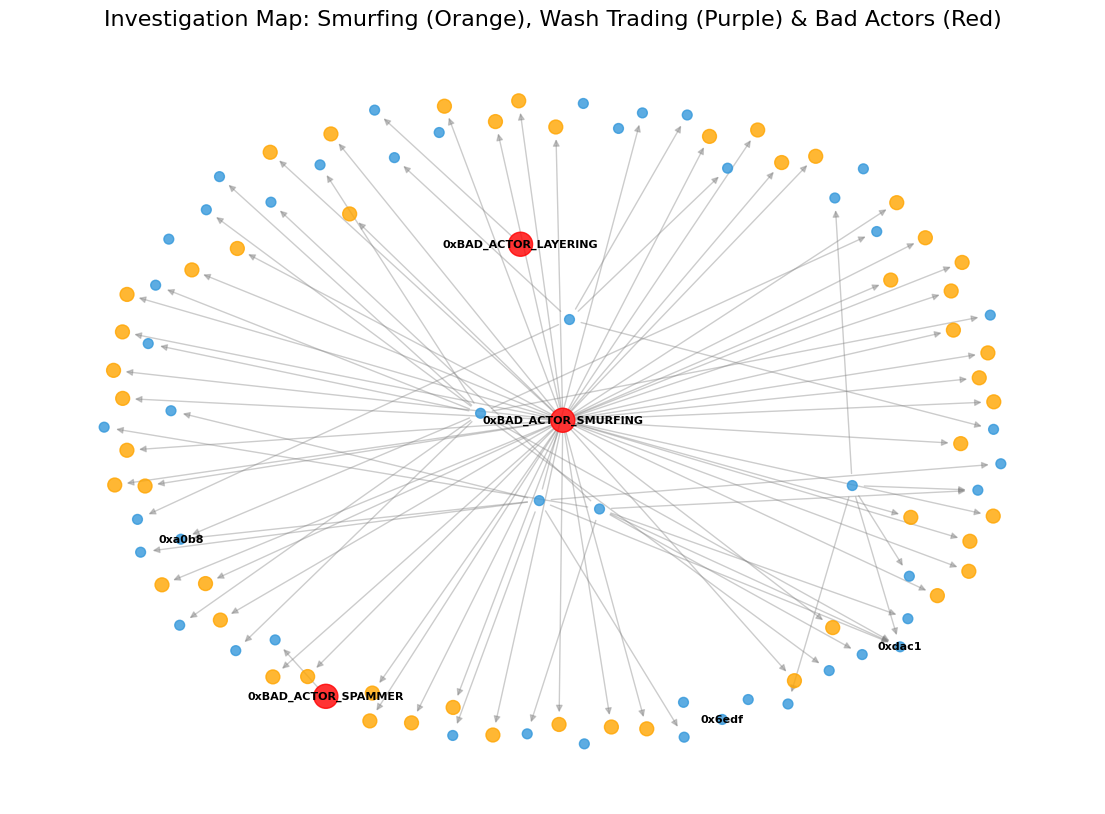

In [12]:
plt.figure(figsize=(14, 10))

nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(H, pos, alpha=0.4, arrows=True, edge_color='gray')

labels = {}
for node in H.nodes():
    if "BAD_ACTOR" in node:
        labels[node] = node
    elif degree_dict.get(node, 0) > 20:
        labels[node] = node[:6]

nx.draw_networkx_labels(H, pos, labels=labels, font_size=8, font_weight='bold')

plt.title("Investigation Map: Smurfing (Orange), Wash Trading (Purple) & Bad Actors (Red)", fontsize=16)
plt.axis('off')

output_dir = '../reports/figures'
if not os.path.exists(output_dir): 
    os.makedirs(output_dir)

plt.savefig(os.path.join(output_dir, 'investigation_graph_final.png'), dpi=300, bbox_inches='tight')
print(f"   ✓ Graph saved to {output_dir}/investigation_graph_final.png")
plt.show()

In [ ]:
print("\n" + "="*70)
print("INTEGRATION COMPLETE")
print("="*70)
print("Results:")
print(f"1. Risk Score CSV/JSON → {len(df_tx)} transactions analyzed")
print(f"2. Graph Visualization PNG → {len(H.nodes())} nodes visualized")
print(f"3. Pattern Detection → {len(unique_wash_trades)} wash trades, {len(mixer_users)} mixer suspects")
print(f"4. Communities Detected → {len(set(partition.values())) if partition else 0} gangs/clusters")


INTEGRATION COMPLETE
Results:
1. Risk Score CSV/JSON → 1152 transactions analyzed
2. Graph Visualization PNG → 101 nodes visualized
3. Pattern Detection → 0 wash trades, 2 mixer suspects
4. Communities Detected → 421 gangs/clusters


: 